## Simulation for galaxy inclinations and expansions with Fourier-Laguerre pairs
- Manual Expansions
- Finding best coefficients limit
- Identifying relation between coefficients/order and inclination angle and comparing various ratios

## Initialising Galaxy Parameters and Importing Packages

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from tqdm import tqdm # progress bar for loops, interrupt if needed
from scipy.optimize import curve_fit
from matplotlib.colors import LinearSegmentedColormap
import os
import glob
from labellines import *




divergent=LinearSegmentedColormap.from_list('divergent', (
    # Edit this gradient at https://eltos.github.io/gradient/#0D7D87-99C6CC-FBFBFB-EE9093-C31E23
    (0.000, (0.051, 0.490, 0.529)),
    (0.250, (0.600, 0.776, 0.800)),
    (0.500, (0.984, 0.984, 0.984)),
    (0.750, (0.933, 0.565, 0.576)),
    (1.000, (0.765, 0.118, 0.137))))

my_gradient = LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#0:0D7D87-20.8:99C6CC-40:B6B66B-60:F47A00-80:EE9093-100:C31E23
    (0.000, (0.051, 0.490, 0.529)),
    (0.208, (0.600, 0.776, 0.800)),
    (0.400, (0.714, 0.714, 0.420)),
    (0.600, (0.957, 0.478, 0.000)),
    (0.800, (0.933, 0.565, 0.576)),
    (1.000, (0.765, 0.118, 0.137))))
#Formatting for plots
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('bmh')
# DiscModel is in a different file
from src.DiscModel import DiscGalaxy
N = 1000000 # number of stars in the disc
a = 1 # a is the scale length of the disc in kpc
D = DiscGalaxy(N=N,a=a)

rmax = 20.
nbins = 64
mmax = 10
nmax = 1

noise = 0.5

"""Recall m corresponds to Fourier (azimuthal) modes, n corresponds to Laguerre (radial harmonics) modes."""

'Recall m corresponds to Fourier (azimuthal) modes, n corresponds to Laguerre (radial harmonics) modes.'

## Manually testing various maximum order

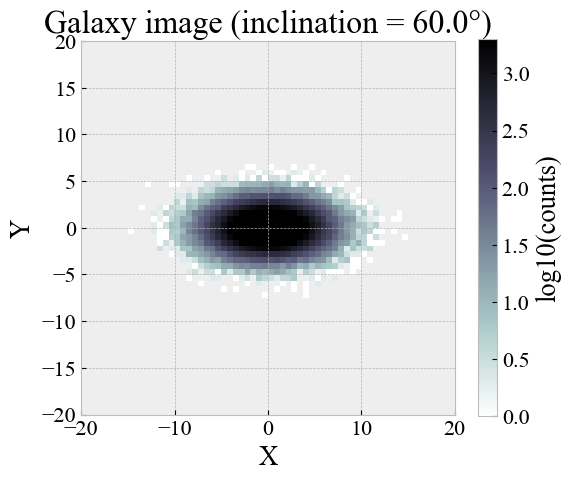

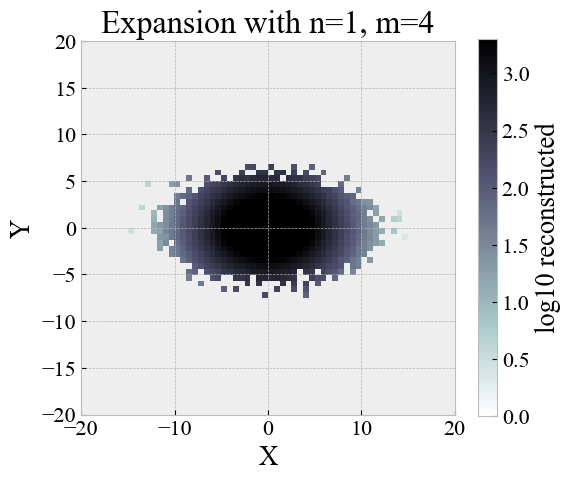

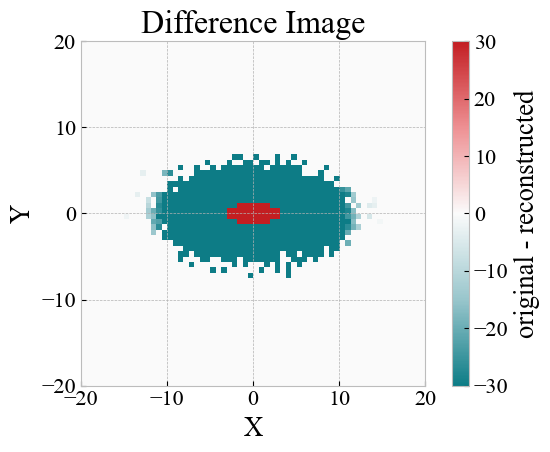

In [3]:
inc = 60.  # degrees, change as needed

"""Generating the galaxy image with the specified inclination"""
D = DiscGalaxy(N=N, a=a)  # adjust N and a as needed
D.rotate_disc(inc, 0, 0)
D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
img_orig = D.img.copy()

# Replace zero pixels with NaN to avoid log10(-inf) warnings

safe_img = np.where(D.img > 0, D.img, np.nan)
log_img = np.log10(safe_img)


"""Plotting the galaxy image"""

plt.figure(figsize=(6, 5))
plt.imshow(log_img, origin='lower', cmap='bone_r',
           extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],
           vmin=0., vmax=3.3)
plt.colorbar(label='log10(counts)')
plt.title(f"Galaxy image (inclination = {inc}°)")
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()


m,n=4,1 #Toggle this to see the expansion coefficients and how they change, goal: find the closest match to the image

E1 = D.make_pointexpansion(m,n,a*1.5,noisy=False) # Expanding the image 

"""Reconstruct an image from the expansion coefficients"""

E1.laguerre_reconstruction(D.r,D.p)

x , y= D.r * np.cos(D.p), D.r * np.sin(D.p) # Convert polar coordinates to Cartesian coordinates

bins = [D.x_edges, D.y_edges]

recon_img, _, _ = np.histogram2d(x, y, bins=bins, weights=E1.reconstruction)
counts, _, _ = np.histogram2d(x, y, bins=bins)
recon_img /= np.maximum(counts, 1)
recon_img *= np.sum(img_orig) / np.sum(recon_img)
recon_img = recon_img.T

safe_recon = np.where(recon_img > 0, recon_img, np.nan)
log_recon = np.log10(safe_recon)

"""Plotting the reconstructed image"""

plt.figure(figsize=(6, 5))
plt.imshow(log_recon, origin='lower', cmap='bone_r',
           extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],
           vmin=0., vmax=3.3)
plt.colorbar(label='log10 reconstructed')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Expansion with n={n}, m={m}')
plt.tight_layout()
plt.show()

"""Plotting the difference between the original and reconstructed images"""
plt.figure()
plt.imshow(D.img - recon_img, origin='lower', cmap=divergent,
           extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],
           vmin=-30., vmax=30.)
plt.colorbar(label='original - reconstructed')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Difference Image")
plt.tight_layout()
plt.show()

## Automating the best coefficients

mmax: 100%|██████████| 5/5 [00:34<00:00,  6.92s/it]

Best match: mmax = 6, nmax = 7, NRMSE = 0.00032



/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_2688/3753007224.py:61: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_orig), origin='lower', cmap='bone_r',


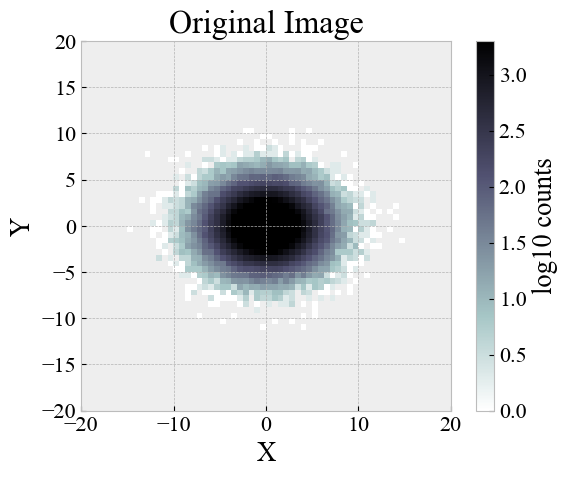

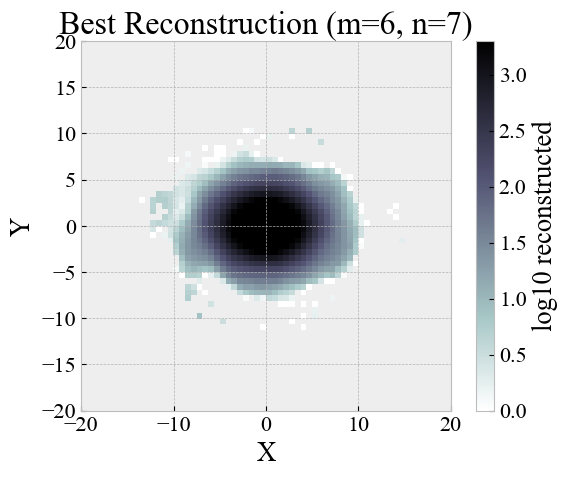

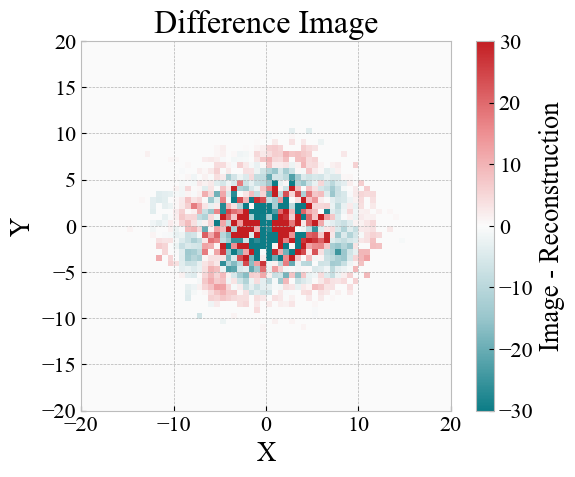

In [4]:
inc = 40. # degrees, change as needed

"""Generating the galaxy image with the specified inclination"""
D = DiscGalaxy(N=N, a=a)
D.rotate_disc(inc, 0, 0)
D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)

img_orig = D.img.copy()
x_edges, y_edges = D.x_edges, D.y_edges

"""Finding the best expansion coefficients"""
# We will try different mmax and nmax values to find the best fit to the original
m_values = range(0, 10, 2) #vary m (even) and n (all) ranges to find the best fit
n_values = range(1, 10, 1) #n=1 corresponds to the 0 laguerre mode.
errors = []
best_error = np.inf
best_config = None
best_E = None

for m in tqdm(m_values, desc="mmax"):
    for n in n_values:
        try:
            E = D.make_pointexpansion(m, n, a*1.5)
            E.laguerre_reconstruction(D.r, D.p)
            recon = E.reconstruction

           # Convert polar coordinates to Cartesian coordinates
            x = D.r * np.cos(D.p)
            y = D.r * np.sin(D.p)
            bins = [x_edges, y_edges]

            recon_img, _, _ = np.histogram2d(x, y, bins=bins, weights=E.reconstruction)
            counts, _, _ = np.histogram2d(x, y, bins=bins)
            recon_img /= np.maximum(counts, 1)
            recon_img *= np.sum(img_orig) / np.sum(recon_img)
            recon_img = recon_img.T
            #Compare to original image
            mask = np.isfinite(img_orig) & np.isfinite(recon_img)
            nrmse = np.sqrt(np.mean((img_orig[mask] - recon_img[mask])**2)) / np.max(img_orig)


            errors.append((m, n, nrmse))

            if nrmse < best_error:
                best_error = nrmse
                best_config = (m, n)
                best_E = E
        except Exception as e:
            print(f"Failed at m={m}, n={n}: {e}")

# Print and plot the best match
m_best, n_best = best_config
print(f"Best match: mmax = {m_best}, nmax = {n_best-1}, NRMSE = {best_error:.5f}")

# n-1 ensures the Laguerre mode is correctly indexed since n=1 corresponds to the 0 Laguerre mode, which we interpret as n=0


"""Plots"""
#Original
plt.figure()
plt.imshow(np.log10(img_orig), origin='lower', cmap='bone_r',
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           vmin=0., vmax=3.3)
plt.colorbar(label='log10 counts')
plt.title("Original Image")
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

#Best Reconstruction
plt.figure()
safe_recon = np.where(recon_img > 0, recon_img, np.nan)
log_recon = np.log10(safe_recon)

plt.imshow(log_recon, origin='lower', cmap='bone_r',
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           vmin=0., vmax=3.3)
plt.colorbar(label='log10 reconstructed')
plt.title(f"Best Reconstruction (m={m_best}, n={n_best-1})")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

#Difference Image

difference = img_orig - recon_img

plt.figure()
plt.imshow(difference, origin='lower', cmap=divergent,
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           vmin=-30, vmax=30)
plt.colorbar(label='Image - Reconstruction')
plt.title("Difference Image")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


## Realising coefficients and their dependence on inclination angle


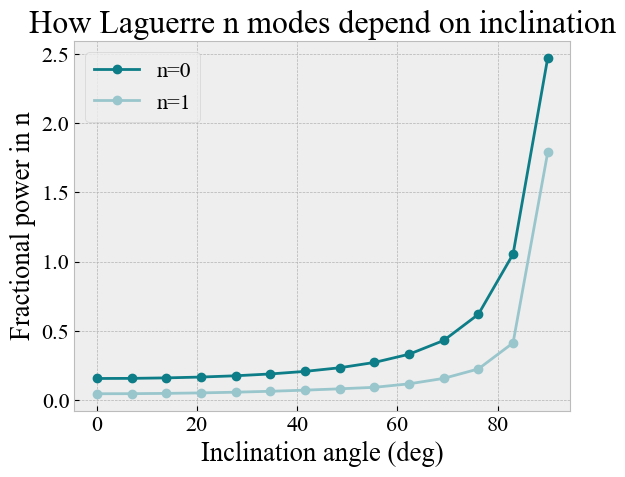

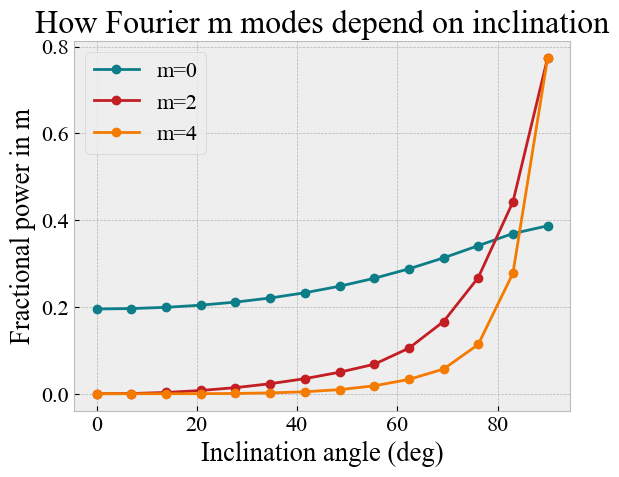

In [5]:
rmax = 11.
nbins = 512
mmax,nmax = 10,2
#n=1 corresponds to the 0 Laguerre mode

# Inclination angles to test, period of 90 degrees, 90 itself results in a fully inclined razor thin disc 
inclinations = np.linspace(0, 90, 14)  # Continuous inclination angles from 0 to 85 degrees

colormap=['#0d7d87', '#99c6cc', '#c31e23', '#ee9093', '#f47a00']

# Store results
results = []

for inc in inclinations:
    D = DiscGalaxy(N=N, a=a)
    D.rotate_disc(inc, 0, 0)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=0.)
    E = D.make_pointexpansion(mmax, nmax, a*1.5)
    
    coef_mag = np.sqrt(E.coscoefs**2 + E.sincoefs**2)
    m_power = np.sum(coef_mag, axis=1)
    n_power = np.sum(coef_mag, axis=0)
    

    results.append({
        "inclination": inc,
        "m_power": m_power,
        "n_power": n_power
    })

# Plot fractional power vs inclination for each n (Laguerre mode)
theta_deg = np.array([r["inclination"] for r in results])
theta_rad = np.radians(theta_deg)

for n in range(0,2,1): #n=0 corresponds to the 0 Laguerre mode because range is used as n in [0,2)
    plt.plot(theta_deg,
             [r["n_power"][n] for r in results],
             marker='o', label=f"n={n}", color=colormap[n])

plt.xlabel("Inclination angle (deg)")
plt.ylabel("Fractional power in n")
plt.legend()
plt.title("How Laguerre n modes depend on inclination")
plt.show()

for m in range(0,5,2):
    plt.plot(theta_deg,
             [r["m_power"][m] for r in results],
             marker='o', label=f"m={m}", color=colormap[m])

plt.xlabel("Inclination angle (deg)")
plt.ylabel("Fractional power in m")
plt.legend()
plt.title("How Fourier m modes depend on inclination")
plt.show()

m=0 most dominant at inc=0 deg because other modes don't appear in face on

## Comparing order ratios

Computing expansions: 100%|██████████| 30/30 [00:12<00:00,  2.44it/s]


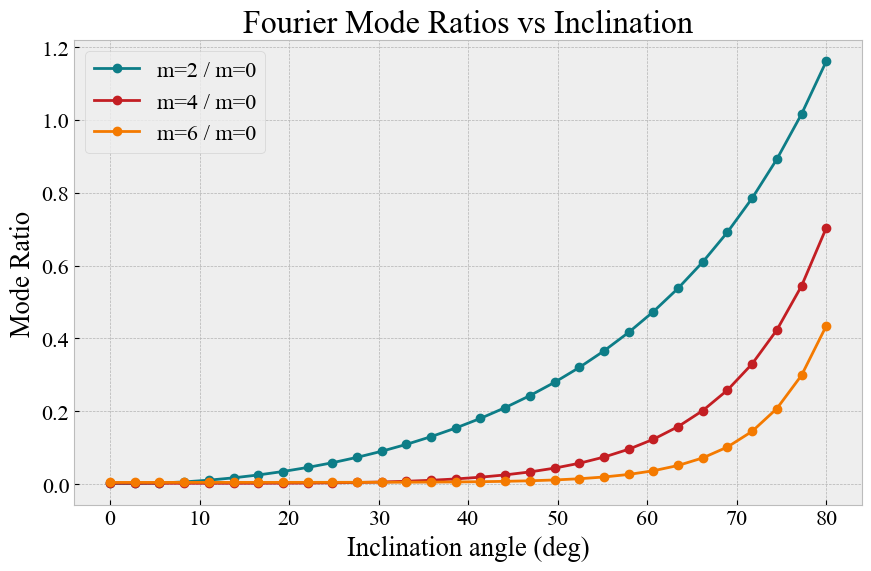

In [6]:
# Inclination angles to scan
inclinations = np.linspace(0, 80, 30)

# Store results
results = []

#Compute power for each inclination
for inc in tqdm(inclinations, desc="Computing expansions"):
    D = DiscGalaxy(N=N, a=a)
    D.rotate_disc(inc, 0, 0)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)

    E = D.make_pointexpansion(mmax, 1, a*1.5)
    
    coef_mag = np.sqrt(E.coscoefs**2 + E.sincoefs**2)
    m_power = np.sum(coef_mag, axis=1)
    n_power = np.sum(coef_mag, axis=0)
    
    results.append({
        "inclination": inc,
        "m_power": m_power,
        "n_power": n_power
    })


theta_rad = np.radians(theta_deg)
theta_deg = np.array([r["inclination"] for r in results])
# Data for Laguerre ratios
""" 
Pn0 = np.array([r["n_power"][0] for r in results])
Pn1 = np.array([r["n_power"][1] for r in results])
Pn2 = np.array([r["n_power"][2] for r in results])
Pn3 = np.array([r["n_power"][3] for r in results])
Pn4 = np.array([r["n_power"][4] for r in results])
Pn5 = np.array([r["n_power"][5] for r in results])
Pn6 = np.array([r["n_power"][6] for r in results])

Rn1 = Pn1 / Pn0
Rn2 = Pn2 / Pn0
Rn3 = Pn3 / Pn0
Rn4 = Pn4 / Pn0
Rn5 = Pn5 / Pn0
Rn6 = Pn6 / Pn0
 """



""" plt.figure(figsize=(9, 6))
colormap=['#0d7d87', '#99c6cc', '#c31e23', '#ee9093', '#f47a00']
plt.plot(theta_deg, Rn1, 'o-', label='n=1 / n=0', color='#0d7d87')
plt.plot(theta_deg, Rn2, 'o-', label='n=2 / n=0', color='#99c6cc')
plt.plot(theta_deg, Rn3, 'o-', label='n=3 / n=0', color='#c31e23')
plt.plot(theta_deg, Rn4, 'o-', label='n=4 / n=0', color='#ee9093')
plt.plot(theta_deg, Rn5, 'o-', label='n=5 / n=0', color='#f47a00')
plt.plot(theta_deg, Rn6, 'o-', label='n=6 / n=0', color='olive')

plt.xlabel("Inclination angle (deg)")
plt.ylabel("Mode Ratio")
plt.title("Laguerre Mode Ratios vs Inclination")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show() """


### Fourier mode ratios vs inclination
# Data
Pm0 = np.array([r["m_power"][0] for r in results])
Pm2 = np.array([r["m_power"][2] for r in results])
Pm4 = np.array([r["m_power"][4] for r in results])
Pm6 = np.array([r["m_power"][6] for r in results])

Rm2 = Pm2 / Pm0
Rm4 = Pm4 / Pm0
Rm6 = Pm6 / Pm0

plt.figure(figsize=(9, 6))

plt.plot(theta_deg, Rm2, 'o-', label='m=2 / m=0', color='#0d7d87' )
plt.plot(theta_deg, Rm4, 'o-', label='m=4 / m=0', color='#c31e23')
plt.plot(theta_deg, Rm6, 'o-', label='m=6 / m=0', color='#f47a00')

plt.xlabel("Inclination angle (deg)")
plt.ylabel("Mode Ratio")
plt.title("Fourier Mode Ratios vs Inclination")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:97: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:97: SyntaxWarning: invalid escape sequence '\s'
/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_2688/3835165939.py:27: SyntaxWarning: invalid escape sequence '\s'
  """ plt.figure(figsize=(8,6))
/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_2688/3835165939.py:97: SyntaxWarning: invalid escape sequence '\s'
  """


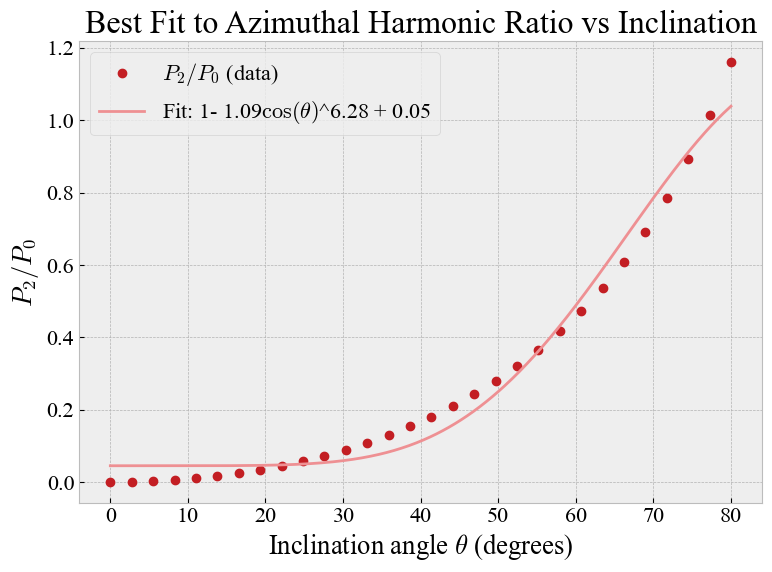

Best fit model: R(theta) = 1.094 sin(theta) ^6.284 + 0.046
RMSE = 0.04387


' \nplt.figure(figsize=(8,6))\nplt.plot(theta_deg, Rmplot, \'o\', label=r\'$P_2/P_0$ Fourier (data)\', color=\'#c31e23\')\nplt.plot(theta_fit, Rm_fit, \'-\', label=rf\'Fourier Fit: {Am_fit:.2f}$\\sin(\theta)$^{Bm_fit:.2f} + {Cm_fit:.2f}\', color=\'#ee9093\')\nplt.plot(theta_deg, Rnplot, \'o\', label=r\'$P_2/P_0$ Laguerre (data)\', color=\'#0d7d87\')\nplt.plot(theta_fit, Rn_fit, \'-\', label=rf\'Laguerre Fit: {An_fit:.2f}$\\sin(\theta)$^{Bn_fit:.2f} + {Cn_fit:.2f}\', color=\'#99c6cc\')\n\nplt.xlabel(r"Inclination angle $\theta$ (degrees)")\nplt.ylabel(r"$P_2 / P_0$")\nplt.title("Best Fit to Fourier and Laguerre Modes vs Inclination")\nplt.legend()\nplt.grid(True)\nplt.tight_layout()\nplt.show() '

In [11]:
colormap=['#0d7d87', '#99c6cc', '#c31e23', '#ee9093', '#f47a00']


#Fitting model
def model(theta_deg, A, B, C):
    theta_rad = np.radians(theta_deg)
    return A * np.sin(theta_rad)**B + C

theta_deg = np.array([r["inclination"] for r in results])

""" 
Rnplot = Rn2
# Fit the model
popt, pcov = curve_fit(model, theta_deg, Rnplot, p0=[0.0, 1.0, 0.0])
An_fit, Bn_fit, Cn_fit = popt

# Evaluate the fit
theta_fit = np.linspace(0, 80, 500)
Rn_fit = model(theta_fit, *popt)

# Compute RMSE
Rn2_pred = model(theta_deg, *popt)
rmse = np.sqrt(np.mean((Rnplot - Rn2_pred)**2)) """


# Plot Laguerre mode ratio and fit
""" plt.figure(figsize=(8,6))
plt.plot(theta_deg, Rnplot, 'o', label=r'$P_2/P_0$ (data)', color='#0d7d87')
plt.plot(theta_fit, Rn_fit, '-', label=rf'Fit: {An_fit:.2f}$\sin(\theta)$^{Bn_fit:.2f} + {Cn_fit:.2f}', color='#99c6cc')
plt.xlabel(r"Inclination angle $\theta$ (degrees)")
plt.ylabel(r"$P_2 / P_0$")
plt.title("Best Fit to Radial Harmonic Ratio vs Inclination")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print formula and RMSE
print(f"Best fit model:\n  R(θ) = {An_fit:.3f}sin(theta)^{Bn_fit:.3f} + {Cn_fit:.3f}")
print(f"RMSE = {rmse:.5f}")
 """
 
 
 
""" Fourier mode ratios vs inclination """

#  Data 

Pm0 = np.array([r["m_power"][0] for r in results])
Pm2 = np.array([r["m_power"][2] for r in results])
Pm4 = np.array([r["m_power"][4] for r in results])
Pm6 = np.array([r["m_power"][6] for r in results])

Rm2 = Pm2 / Pm0
Rm4 = Pm4 / Pm0
Rm6 = Pm6 / Pm0 # mode ratio 
Rm6_4= Pm6 / Pm4  # ratio of m=6 to m=4
Rm4_2= Pm4 / Pm2  # ratio of m=4 to m=2

Rmplot=Rm2

#Fitting model
def model(theta_deg, A, B, C):
    theta_rad = np.radians(theta_deg)
    return A * np.sin(theta_rad)**B + C

# Fit the model
popt, pcov = curve_fit(model, theta_deg, Rmplot, p0=[1.0, 0.1, 0.01])
Am_fit, Bm_fit, Cm_fit = popt

# Evaluate the fit
theta_fit = np.linspace(0, 80, 500)
Rm_fit = model(theta_fit, *popt)

# Compute RMSE
Rm2_pred = model(theta_deg, *popt)
rmse = np.sqrt(np.mean((Rmplot - Rm2_pred)**2))

# Plot 
plt.figure(figsize=(8,6))
plt.plot(theta_deg, Rmplot, 'o', label=r'$P_2/P_0$ (data)', color='#c31e23')
plt.plot(theta_fit, Rm_fit, '-', label=rf'Fit: 1- {Am_fit:.2f}$\cos(\theta)$^{Bm_fit:.2f} + {Cm_fit:.2f}', color='#ee9093')

plt.xlabel(r"Inclination angle $\theta$ (degrees)")
plt.ylabel(r"$P_2 / P_0$")
plt.title("Best Fit to Azimuthal Harmonic Ratio vs Inclination")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print formula and RMSE
print(rf"Best fit model: R(theta) = {Am_fit:.3f} sin(theta) ^{Bm_fit:.3f} + {Cm_fit:.3f}")
print(f"RMSE = {rmse:.5f}") 

#Plot both Laguerre and Fourier mode ratios with fits
""" 
plt.figure(figsize=(8,6))
plt.plot(theta_deg, Rmplot, 'o', label=r'$P_2/P_0$ Fourier (data)', color='#c31e23')
plt.plot(theta_fit, Rm_fit, '-', label=rf'Fourier Fit: {Am_fit:.2f}$\sin(\theta)$^{Bm_fit:.2f} + {Cm_fit:.2f}', color='#ee9093')
plt.plot(theta_deg, Rnplot, 'o', label=r'$P_2/P_0$ Laguerre (data)', color='#0d7d87')
plt.plot(theta_fit, Rn_fit, '-', label=rf'Laguerre Fit: {An_fit:.2f}$\sin(\theta)$^{Bn_fit:.2f} + {Cn_fit:.2f}', color='#99c6cc')

plt.xlabel(r"Inclination angle $\theta$ (degrees)")
plt.ylabel(r"$P_2 / P_0$")
plt.title("Best Fit to Fourier and Laguerre Modes vs Inclination")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show() """



dependence only on $\theta$, no additional factor in argument

## Comparing with real galaxy data and testing relations

In [ ]:
def estimate_inclination(R, A, B, C):
    if R < C or ((R - C) / A) ** B > 1:
        print("R is outside the valid inversion range.")
        estimated_incl = np.nan
    else:
        theta_rad = np.arcsin(((R - C) / A) ** (1/B))
        estimated_incl = np.degrees(theta_rad)
        return estimated_incl

data1=np.load('flux_expansion_data_12070-9102.npy', allow_pickle=True)[()]
data2=np.load('flux_expansion_data_7443-12703.npy', allow_pickle=True)[()]
data3=np.load('flux_expansion_data_7443-6104.npy', allow_pickle=True)[()]
data4=np.load('flux_expansion_data_7960-12701.npy', allow_pickle=True)[()]
data5=np.load('flux_expansion_data_7960-12703.npy', allow_pickle=True)[()]
data6=np.load('flux_expansion_data_7960-12704.npy', allow_pickle=True)[()]
data7=np.load('flux_expansion_data_7960-12705.npy', allow_pickle=True)[()]
data8=np.load('flux_expansion_data_7960-3701-2.npy', allow_pickle=True)[()]
data9=np.load('flux_expansion_data_7960-3702.npy', allow_pickle=True)[()]
data10=np.load('flux_expansion_data_7960-6101.npy', allow_pickle=True)[()]
data11=np.load('flux_expansion_data_7960-6102.npy', allow_pickle=True)[()]
data12=np.load('flux_expansion_data_8600-6104.npy', allow_pickle=True)[()]

coscoefs1 = data1['coscoefs']
sincoefs1 = data1['sincoefs']    
coscoefs2 = data2['coscoefs']
sincoefs2 = data2['sincoefs']
coscoefs3 = data3['coscoefs']
sincoefs3 = data3['sincoefs']
coscoefs4 = data4['coscoefs']
sincoefs4 = data4['sincoefs']   
coscoefs5 = data5['coscoefs']
sincoefs5 = data5['sincoefs']   
coscoefs6 = data6['coscoefs']
sincoefs6 = data6['sincoefs']
coscoefs7 = data7['coscoefs']
sincoefs7 = data7['sincoefs']
coscoefs8 = data8['coscoefs']
sincoefs8 = data8['sincoefs']
coscoefs9 = data9['coscoefs']
sincoefs9 = data9['sincoefs']
coscoefs10 = data10['coscoefs']
sincoefs10 = data10['sincoefs']    
coscoefs11 = data11['coscoefs']
sincoefs11 = data11['sincoefs']
coscoefs12 = data12['coscoefs']
sincoefs12 = data12['sincoefs']


P0 = np.sqrt(coscoefs1[0, 0,0]**2 + sincoefs1[0, 0,0]**2)
P2 = np.sqrt(coscoefs1[0, 0,2]**2 + sincoefs1[0, 0,2]**2)  
R2_0_1= P2 / P0  # Ratio of n=2 to n=0
true_inclination= data1['inclination']* 180/np.pi  # Convert from radians to degrees
print(true_inclination)
print("Estimated inclination for data1:", estimate_inclination(R2_0_1, Am_fit, Bm_fit, Cm_fit))

P0_2 = np.sqrt(coscoefs2[0, 0,0]**2 + sincoefs2[0, 0,0]**2)
P2_2 = np.sqrt(coscoefs2[0, 0,2]**2 + sincoefs2[0, 0,2]**2)
R2_0_2 = P2_2 / P0_2  # Ratio of n=2 to n=0
true_inclination_2 = data2['inclination'][0] * 180/np.pi  # Convert from radians to degrees
print(true_inclination_2)  
print("Estimated fourier inclination for data2:", estimate_inclination(R2_0_2, Am_fit, Bm_fit, Cm_fit))

P0_3 = np.sqrt(coscoefs3[0, 0,0]**2 + sincoefs3[0, 0,0]**2)
P2_3 = np.sqrt(coscoefs3[0, 0,2]**2 + sincoefs3[0, 0,2]**2)
R2_0_3 = P2_3 / P0_3  # Ratio of n=2 to n=0
true_inclination_3 = data3['inclination'][0] * 180/np.pi  # Convert from radians to degrees
print(true_inclination_3)
print("Estimated inclination for data3:", estimate_inclination(R2_0_3, Am_fit, Bm_fit, Cm_fit)) 

P0_4 = np.sqrt(coscoefs4[0, 0,0]**2 + sincoefs4[0, 0,0]**2)
P2_4 = np.sqrt(coscoefs4[0, 0,2]**2 + sincoefs4[0, 0,2]**2)
R2_0_4 = P2_4 / P0_4  # Ratio of n=2 to n=0
true_inclination_4 = data4['inclination'][0] * 180/np.pi  # Convert from radians to degrees
print(true_inclination_4)
print("Estimated inclination for data4:", estimate_inclination(R2_0_4, Am_fit, Bm_fit, Cm_fit))

P0_5 = np.sqrt(coscoefs5[0, 0,0]**2 + sincoefs5[0, 0,0]**2)
P2_5 = np.sqrt(coscoefs5[0, 0,2]**2 + sincoefs5[0, 0,2]**2)
R2_0_5 = P2_5 / P0_5  # Ratio of n=2 to n=0
true_inclination_5 = data5['inclination'][0] * 180/np.pi  # Convert from radians to degrees
print(true_inclination_5)
print("Estimated inclination for data5:", estimate_inclination(R2_0_5, Am_fit, Bm_fit, Cm_fit)) 

P0_6 = np.sqrt(coscoefs6[0, 0,0]**2 + sincoefs6[0, 0,0]**2)
P2_6 = np.sqrt(coscoefs6[0, 0,2]**2 + sincoefs6[0, 0,2]**2)
R2_0_6 = P2_6 / P0_6  # Ratio of n=2 to n=0
true_inclination_6 = data6['inclination'][0] * 180/np.pi  # Convert from radians to degrees
print(true_inclination_6)
print("Estimated inclination for data6:", estimate_inclination(R2_0_6, Am_fit, Bm_fit, Cm_fit)) 

P0_7 = np.sqrt(coscoefs7[0, 0,0]**2 + sincoefs7[0, 0,0]**2)
P2_7 = np.sqrt(coscoefs7[0, 0,2]**2 + sincoefs7[0, 0,2]**2)
R2_0_7 = P2_7 / P0_7  # Ratio of n=2 to n=0
true_inclination_7 = data7['inclination'][0] * 180/np.pi  # Convert from radians to degrees
print(true_inclination_7)
print("Estimated inclination for data7:", estimate_inclination(R2_0_7, Am_fit, Bm_fit, Cm_fit))

P0_8 = np.sqrt(coscoefs8[0, 0,0]**2 + sincoefs8[0, 0,0]**2)
P2_8 = np.sqrt(coscoefs8[0, 0,2]**2 + sincoefs8[0, 0,2]**2)
R2_0_8 = P2_8 / P0_8  # Ratio of n=2 to n=0
true_inclination_8 = data8['inclination'][0] * 180/np.pi       
print(true_inclination_8)
print("Estimated inclination for data8:", estimate_inclination(R2_0_8, Am_fit, Bm_fit, Cm_fit))

P0_9 = np.sqrt(coscoefs9[0, 0,0]**2 + sincoefs9[0, 0,0]**2)
P2_9 = np.sqrt(coscoefs9[0, 0,2]**2 + sincoefs9[0, 0,2]**2)
R2_0_9 = P2_9 / P0_9  # Ratio of n  =2 to n=0
true_inclination_9 = data9['inclination'][0] * 180/np.pi  # Convert from radians to degrees
print(true_inclination_9)
print("Estimated inclination for data9:", estimate_inclination(R2_0_9, Am_fit, Bm_fit, Cm_fit))
 
P0_10 = np.sqrt(coscoefs10[0, 0,0]**2 + sincoefs10[0, 0,0]**2)
P2_10 = np.sqrt(coscoefs10[0, 0,2]**2 + sincoefs10[0, 0,2]**2)
R2_0_10 = P2_10 / P0_10  # Ratio of n=2 to n=0
true_inclination_10 = data10['inclination'][0] * 180/np.pi  # Convert from radians to degrees
print(true_inclination_10)
print("Estimated inclination for data10:", estimate_inclination(R2_0_10, Am_fit, Bm_fit, Cm_fit))

P0_11 = np.sqrt(coscoefs11[0, 0,0]**2 + sincoefs11[0, 0,0]**2)
P2_11 = np.sqrt(coscoefs11[0, 0,2]**2 + sincoefs11[0, 0,2]**2)
R2_0_11 = P2_11 / P0_11  # Ratio of n=2 to n=0
true_inclination_11 = data11['inclination'][0] * 180/np.pi  # Convert from radians to degrees
print(true_inclination_11)
print("Estimated inclination for data11:", estimate_inclination(R2_0_11, Am_fit, Bm_fit, Cm_fit))

P0_12 = np.sqrt(coscoefs12[0, 0,0]**2 + sincoefs12[0, 0,0]**2)
P2_12 = np.sqrt(coscoefs12[0, 0,2]**2 + sincoefs12[0, 0,2]**2)
R2_0_12 = P2_12 / P0_12  # Ratio of n=2 to n=0
true_inclination_12 = data12['inclination'][0] * 180/np.pi  # Convert from radians to degrees
print(true_inclination_12)
print("Estimated inclination for data12:", estimate_inclination(R2_0_12, Am_fit, Bm_fit, Cm_fit))


[30.48118868]
Estimated inclination for data1: 60.15052178328614
38.48985472161274
Estimated fourier inclination for data2: 53.7473656210351
39.756473515192816
Estimated inclination for data3: 60.7440338236104
32.25197758849604
Estimated inclination for data4: 45.468854729275485
51.75171662055977
Estimated inclination for data5: 55.27647789596206
51.57523862604793
Estimated inclination for data6: 20.578260791637398
34.822289237521375
Estimated inclination for data7: 55.091903099260996
56.34441950003122
Estimated inclination for data8: 68.68766431435805
56.74699716244094
Estimated inclination for data9: 63.2143511865403
49.86046188616046
R is outside the valid inversion range.
Estimated inclination for data10: None
50.0081199835965
Estimated inclination for data11: 49.95069911283062
16.07754009982238
Estimated inclination for data12: 65.74456456050403


R is outside the valid inversion range.


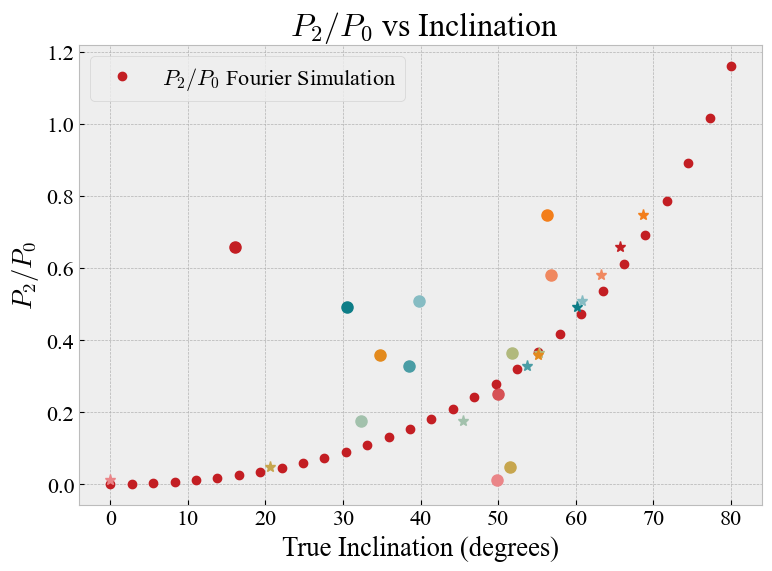

' # Predict new ratio\nnew_inclination = 60\npredicted_ratio = sin_model(new_inclination, *popt)\nprint("Predicted P2/P0 at 60°:", predicted_ratio) '

In [ ]:
from scipy.optimize import curve_fit


def sin_model(theta_deg, A, B, C):
    theta_rad = np.radians(theta_deg)
    return A * np.sin(theta_rad)**B + C

# Your actual data
incl = np.array([
    data1['inclination'][0], data2['inclination'][0], data3['inclination'][0],
    data4['inclination'][0], data5['inclination'][0], data6['inclination'][0],
    data7['inclination'][0], data8['inclination'][0], data9['inclination'][0],
    data10['inclination'][0], data11['inclination'][0], data12['inclination'][0]
]) * 180 / np.pi

ratios = np.array([
    R2_0_1, R2_0_2, R2_0_3, R2_0_4, R2_0_5, R2_0_6,
    R2_0_7, R2_0_8, R2_0_9, R2_0_10, R2_0_11, R2_0_12
])


test_incl=np.array([estimate_inclination(R2_0_1, Am_fit, Bm_fit, Cm_fit),
                    estimate_inclination(R2_0_2, Am_fit, Bm_fit, Cm_fit),
                    estimate_inclination(R2_0_3, Am_fit, Bm_fit, Cm_fit),
                    estimate_inclination(R2_0_4, Am_fit, Bm_fit, Cm_fit),
                    estimate_inclination(R2_0_5, Am_fit, Bm_fit, Cm_fit),
                    estimate_inclination(R2_0_6, Am_fit, Bm_fit, Cm_fit),
                    estimate_inclination(R2_0_7, Am_fit, Bm_fit, Cm_fit),
                    estimate_inclination(R2_0_8, Am_fit, Bm_fit, Cm_fit),
                    estimate_inclination(R2_0_9, Am_fit, Bm_fit, Cm_fit),
                    estimate_inclination(R2_0_10, Am_fit, Bm_fit, Cm_fit),
                    estimate_inclination(R2_0_11, Am_fit, Bm_fit, Cm_fit),
                    estimate_inclination(R2_0_12, Am_fit, Bm_fit, Cm_fit)
                    ])
# Fit the sinusoidal model
popt, _ = curve_fit(sin_model, incl, ratios, p0=[1, 2, 0])
A_fit, B_fit, C_fit = popt

# Plotting
theta_vals = np.linspace(0, 90, 500)
fit_vals = sin_model(theta_vals, *popt)

plt.figure(figsize=(8, 6))
colorindx = np.linspace(0, 1, len(ratios))
for i in range(len(incl)):
    plt.plot(incl[i], ratios[i], 'o', color=my_gradient(colorindx[i]), markersize=8)
# plt.plot(incl, ratios, 'o', label='Data', color=colours)
#plt.plot(theta_vals, fit_vals, '-', label=f'Fit: A*sin(θ)^B + C\nA={A_fit:.3f}, B={B_fit:.3f}, C={C_fit:.3f}', color='darkorange')
nonmask = (test_incl == None)
test_incl[nonmask] = 0
plt.plot(theta_deg, Rmplot, 'o', label=r'$P_2/P_0$ Fourier Simulation', color='#c31e23')
# plt.plot(test_incl,test_ratios, 'o', label='Estimated Inclinations', color=colours)
for i in range(len(test_incl)):
    plt.plot(test_incl[i], ratios[i], '*', color=my_gradient(colorindx[i]), markersize=8)
plt.xlabel("True Inclination (degrees)")
plt.ylabel(r"$P_2/P_0$")
plt.title(r" $P_2/P_0$ vs Inclination")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



R is outside the valid inversion range.


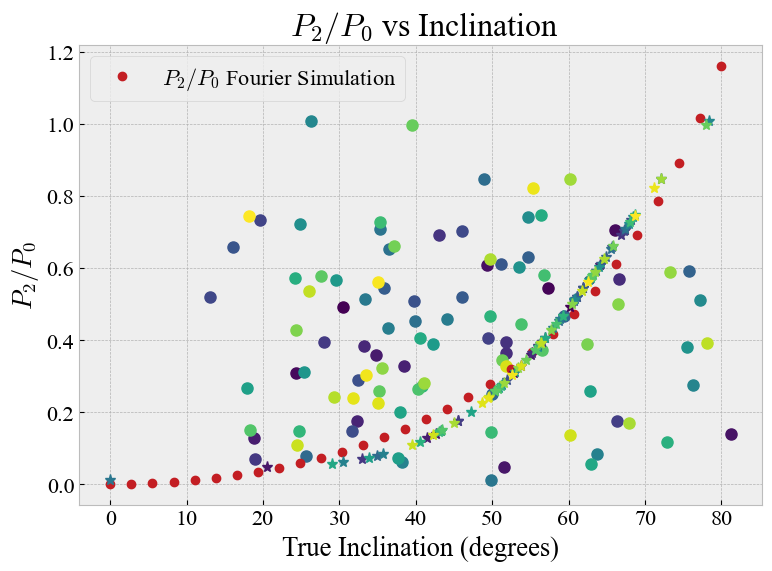

In [ ]:
npy_files=glob.glob('data/*')

inclinations = []
ratios = []
test_incl = []

for file in npy_files:
   
    data = np.load(file, allow_pickle=True)[()]
    coscoefs = data['coscoefs']
    sincoefs = data['sincoefs']

    P0 = np.sqrt(coscoefs[0,0,0]**2 + sincoefs[0,0,0]**2)
    P2 = np.sqrt(coscoefs[0,0,2]**2 + sincoefs[0,0,2]**2)
    ratio = P2 / P0

    # Inclination in degrees
    inclination_deg = data['inclination'][0] * 180 / np.pi
    test_incl.append(estimate_inclination(ratio, Am_fit, Bm_fit, Cm_fit))
    
    # Store
    inclinations.append(inclination_deg)
    ratios.append(ratio)


#plot
inclinations = np.array(inclinations)
ratios = np.array(ratios)
test_incl = np.array(test_incl)

plt.figure(figsize=(8, 6))
colours = plt.cm.viridis(np.linspace(0, 1, len(inclinations)))
for i in range(len(inclinations)):
    plt.plot(inclinations[i], ratios[i], 'o', color=colours[i], markersize=8)
nonmask = (test_incl == None)
test_incl[nonmask] = 0
plt.plot(theta_deg, Rmplot, 'o', label=r'$P_2/P_0$ Fourier Simulation', color='#c31e23')
for i in range(len(test_incl)):
    plt.plot(test_incl[i], ratios[i], '*', color=colours[i], markersize=8)
plt.xlabel("True Inclination (degrees)")
plt.ylabel(r"$P_2/P_0$")
plt.title(r" $P_2/P_0$ vs Inclination")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


